In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit, logit, comb
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

import sys
sys.path.append('../utils/')
import psix_functions as px
%run -i '~/psix/data_analysis/analysis_utils.py'
%run -i '~/sc_splicing_regulation/utils/utils_functions.py'

100%|██████████| 202/202 [00:01<00:00, 169.62it/s]


In [2]:
# chen_kw2, chen_kw_1, chen_kw_25, chen_elife = get_elife_tests(chen_rd, chen_PSI, 
#                                                             chen_mrna_event, chen_psix, n_clusters = 5)

In [2]:
chen_reads = pd.read_csv('~/data_sc_regulation/chen_extended/skipped_exons_SJreads.tab', sep='\t',
                            index_col = 0)
chen_reads = chen_reads.loc[chen_PSI.index & chen_reads.index, chen_PSI.columns]

chen_reads_adj = chen_reads/(1+chen_PSI)

song_reads = pd.read_csv('~/data_sc_regulation/song/skipped_exons_SJreads.tab', sep='\t',
                            index_col = 0)
song_reads = song_reads.loc[song_PSI.index, song_PSI.columns]

song_reads_adj = song_reads/(1+song_PSI)

tiklova_reads = pd.read_csv('~/data_sc_regulation/tiklova_extended/skipped_exons_SJreads.tab', sep='\t',
                            index_col = 0)
tiklova_reads = tiklova_reads.loc[tiklova_PSI.index, tiklova_PSI.columns]

tiklova_reads_adj = tiklova_reads/(1+tiklova_PSI)

In [3]:
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_splicing_regulation/utils/')
from utils_functions import *

hubbard_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Hubbard_pvals.tab', sep='\t', index_col=0)
hubbard_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Hubbard_fdr.tab', sep='\t', index_col=0)
hubbard_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Hubbard_psi.tab', sep='\t', index_col=0)

hubbard_ds = get_averages_bulk(hubbard_psi)
chen_kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/chen_kw.tab', 
                                sep='\t', index_col=0)

song_bulk_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/song_bulk_pvals.tab', sep='\t', index_col=0)
song_bulk_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/song_bulk_fdr.tab', sep='\t', index_col=0)
song_bulk_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/song_bulk_psi.tab', sep='\t', index_col=0)

song_bulk_ds = get_averages_bulk(song_bulk_psi)
song_kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/song_kw.tab', 
                                sep='\t', index_col=0)

weyn_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_pvals.tab', sep='\t', index_col=0)
weyn_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_fdr.tab', sep='\t', index_col=0)
weyn_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_psi.tab', sep='\t', index_col=0)

weyn_ds = get_averages_bulk(weyn_psi)
tiklova_kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', 
                                sep='\t', index_col=0)

In [4]:
tiklova_geary = pd.read_csv(
    '~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_autocorr/tiklova_GearyC_k100.tab',
    sep='\t', index_col=0)
chen_geary = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/chen_autocor/chen_GearyC_k30.tab',
    sep='\t', index_col=0)
song_geary = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/song_autocor/song_GearyC_k30.tab',
    sep='\t', index_col=0)

In [18]:
from statsmodels.stats.multitest import multipletests

tiklova_geary['qvals'] = multipletests(tiklova_geary.pval, method='fdr_bh')[1]
chen_geary['qvals'] = multipletests(chen_geary.pval, method='fdr_bh')[1]
song_geary['qvals'] = multipletests(song_geary.pval, method='fdr_bh')[1]

In [92]:
tiklova_meta = pd.read_csv('~/data_sc_regulation/tiklova/SraRunTable.txt', sep=',', index_col=0)

e13 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 13.5'] & tiklova_rd.index
e15 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 15.5'] & tiklova_rd.index
e18 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 18.5'] & tiklova_rd.index
p1 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 1'] & tiklova_rd.index
p7 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 7'] & tiklova_rd.index
p90 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 90'] & tiklova_rd.index

tiklova_labels = [e13, e15, e18, p1, p7, p90]
from scipy.stats import kruskal

def run_kw(exon_psi, labels):
    kw_input = []
    for l in labels:
        kw_input.append(list(exon_psi.loc[l]))
        
    if len(labels) == 2:
        return kruskal(kw_input[0], kw_input[1], nan_policy='omit')
    if len(labels) == 3:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], nan_policy='omit')
    if len(labels) == 4:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], nan_policy='omit')
    if len(labels) == 5:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], nan_policy='omit')
    if len(labels) == 6:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], nan_policy='omit')
    
def run_kw_dset(psi_table, labels, exon_list):
    kw_output = pd.DataFrame()
    kw_score = []
    pvals = []
    for exon in exon_list:
        score, p = run_kw(psi_table.loc[exon], labels)
        kw_score.append(score)
        pvals.append(p)
    kw_output['KW_score'] = kw_score
    kw_output['pvals'] = pvals
    kw_output['qvals'] = multipletests(pvals, method='fdr_bh')[1]
    kw_output.index = exon_list
    return kw_output

tiklova_kw_labels = run_kw_dset(tiklova_PSI, tiklova_labels, tiklova_psix.index)

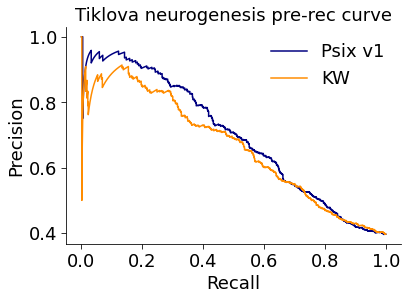

In [76]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
L_score_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
# psix_v2_y = list(tiklova_psix.loc[weyn_pos & exons].psix_v2) + list(tiklova_psix.loc[weyn_neg & exons].psix_v2)
kw_y = list(tiklova_kw_labels.loc[weyn_pos & exons].KW_score) + list(tiklova_kw_labels.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, L_score_y)
# pre2, rec2, thres2 = precision_recall_curve(y1, psix_v2_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix v1')
# plt.plot(rec2, pre2, c='forestgreen', label='Psix v2')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('Tiklova neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

In [93]:
song_meta = pd.read_csv('~/RNASeq/Human/Botvinnik/SraRunTable.txt', sep='\t', index_col=7)
chen_meta = pd.read_csv('~/RNASeq/Mouse/ChenRNASeq/SraRunTable.txt', sep='\t', index_col=5)

ipsc = song_meta.index[song_meta.cell_type_s == 'Skin fibroblast-derived induced pluripotent cells (iPSCs)'] & song_rd.index
npc = song_meta.index[song_meta.cell_type_s == 'iPSC-derived neural progenitor cells'] & song_rd.index
mn = song_meta.index[song_meta.cell_type_s == 'iPSC-derived motor neurons'] & song_rd.index

song_labels = [ipsc, npc, mn]

song_kw_labels = run_kw_dset(song_PSI, song_labels, song_psix.index)


es2i = chen_meta.index[chen_meta.cell_type_s == 'ES2i'] & chen_rd.index
es = chen_meta.index[chen_meta.cell_type_s == 'ES'] & chen_rd.index
epi = chen_meta.index[chen_meta.cell_type_s == 'Epi'] & chen_rd.index
neu = chen_meta.index[chen_meta.cell_type_s == 'Motor neuron'] & chen_rd.index

chen_labels = [es2i, es, epi, neu]

chen_kw_labels = run_kw_dset(chen_PSI, chen_labels, chen_psix.index)

In [94]:
song_kw_labels

,KW_score,pvals,qvals
AASS_nmdSE_3,0.351043,8.390192e-01,8.969541e-01
ABI2_nmdSE_5,4.725188,9.417563e-02,2.154712e-01
ACAP2_1,3.325678,1.895999e-01,3.438395e-01
ACD_2,4.958071,8.382402e-02,1.985867e-01
ACO2_4,0.112728,9.451949e-01,9.667103e-01
...,...,...,...
MYL6_5,79.853444,4.571355e-18,1.191295e-15
MYL6_6,108.212993,3.175755e-24,2.758673e-21
RPLP0_10,3.284693,1.935254e-01,3.470938e-01
RPLP0_nmdSE_1,3.343515,1.879165e-01,3.418659e-01


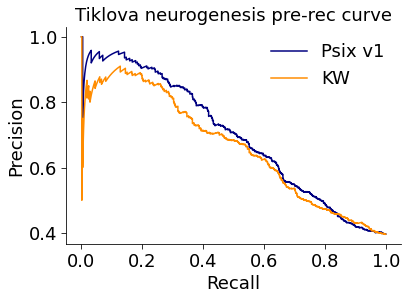

In [5]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
L_score_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
# psix_v2_y = list(tiklova_psix.loc[weyn_pos & exons].psix_v2) + list(tiklova_psix.loc[weyn_neg & exons].psix_v2)
kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, L_score_y)
# pre2, rec2, thres2 = precision_recall_curve(y1, psix_v2_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix v1')
# plt.plot(rec2, pre2, c='forestgreen', label='Psix v2')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('Tiklova neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

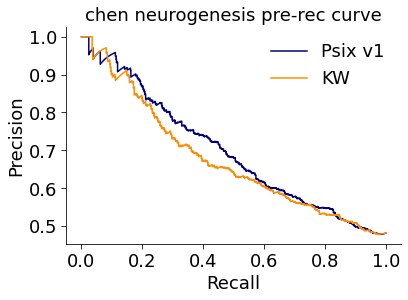

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = chen_psix.index
y1 = [1]*len(hubbard_pos & exons) + [0]*len(hubbard_neg & exons)
L_score_y = list(chen_psix.loc[hubbard_pos & exons].L_score) + list(chen_psix.loc[hubbard_neg & exons].L_score)
# psix_v2_y = list(chen_psix.loc[hubbard_pos & exons].psix_v2) + list(chen_psix.loc[hubbard_neg & exons].psix_v2)
kw_y = list(chen_kw.loc[hubbard_pos & exons].KW_score) + list(chen_kw.loc[hubbard_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, L_score_y)
# pre2, rec2, thres2 = precision_recall_curve(y1, psix_v2_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix v1')
# plt.plot(rec2, pre2, c='forestgreen', label='Psix v2')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('chen neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

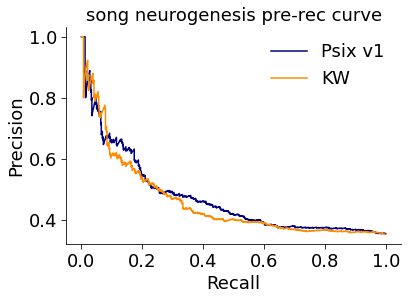

In [7]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

song_bulk_pos = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) >= 0.2) & (song_bulk_fdr.min(axis=1) <= 0.05)]
song_bulk_neg = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) < 0.2) | (song_bulk_fdr.min(axis=1) > 0.05)]

exons = song_psix.index
y1 = [1]*len(song_bulk_pos & exons) + [0]*len(song_bulk_neg & exons)
L_score_y = list(song_psix.loc[song_bulk_pos & exons].L_score) + list(song_psix.loc[song_bulk_neg & exons].L_score)
# psix_v2_y = list(song_psix.loc[song_bulk_pos & exons].psix_v2) + list(song_psix.loc[song_bulk_neg & exons].psix_v2)
kw_y = list(song_kw.loc[song_bulk_pos & exons].KW_score) + list(song_kw.loc[song_bulk_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, L_score_y)
# pre2, rec2, thres2 = precision_recall_curve(y1, psix_v2_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix v1')
# plt.plot(rec2, pre2, c='forestgreen', label='Psix v2')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('song neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

In [7]:
# tiklova_kw_scores_clusters = pd.DataFrame()
# chen_kw_scores_clusters = pd.DataFrame()
# song_kw_scores_clusters = pd.DataFrame()
# for n_clusters in tqdm(np.arange(2, 11)):
#     chen_kw_scores, chen_kw_1, chen_kw_25, chen_elife = get_elife_tests(chen_rd, chen_PSI, 
#                                                             chen_mrna_event, chen_psix, n_clusters = n_clusters)
#     chen_kw_scores_clusters['cluster_'+str(n_clusters)] = chen_kw_scores.KW_score
    
#     tiklova_kw_scores, tiklova_kw_1, tiklova_kw_25, tiklova_elife = get_elife_tests(tiklova_rd, tiklova_PSI, 
#                                                             tiklova_mrna_event, tiklova_psix, n_clusters = n_clusters)
#     tiklova_kw_scores_clusters['cluster_'+str(n_clusters)] = tiklova_kw_scores.KW_score
    
#     song_kw_scores, song_kw_1, song_kw_25, song_elife = get_elife_tests(song_rd, song_PSI, 
#                                                             song_mrna_event, song_psix, n_clusters = n_clusters)
#     song_kw_scores_clusters['cluster_'+str(n_clusters)] = song_kw_scores.KW_score
    
#     chen_kw_scores_clusters.index = chen_kw_scores.index
#     tiklova_kw_scores_clusters.index = tiklova_kw_scores.index
#     song_kw_scores_clusters.index = song_kw_scores.index
    
    
# tiklova_kw_scores_clusters.to_csv('~/tiklova_kw_clusters.tab', sep='\t', index=True, header=True)
# chen_kw_scores_clusters.to_csv('~/chen_kw_clusters.tab', sep='\t', index=True, header=True)
# song_kw_scores_clusters.to_csv('~/song_kw_clusters.tab', sep='\t', index=True, header=True)

100%|██████████| 9/9 [34:42<00:00, 231.39s/it]


 38%|███▊      | 753/1988 [01:12<02:24,  8.55it/s]../utils/psix_functions.py:129: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))
 96%|█████████▌| 1903/1988 [03:39<00:19,  4.34it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 99%|█████████▉| 1964/1988 [03:51<00:04,  5.26it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
 99%|█████████▉| 1968/1988 [03:52<00:04,  4.41it/s]../utils/psix_functions.py:46: RuntimeWarning: overflow encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
../utils/psix_functions.py:46: RuntimeWarning: invalid value encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
100%|██████████| 1988/1988 [03:57<00:00,  8.38it/s]


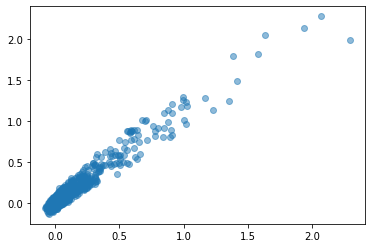

In [19]:
L_list = []
for exon in tqdm(tiklova_psix.index):
    L = px.calculate_exon_L(tiklova_PSI, W_tiklova, tiklova_reads_adj, exon, c = 0.1, 
                 randomize = False)
    L_list.append(L)

tiklova_psix['L_reads'] = L_list
plt.scatter(tiklova_psix.L_score, L_list, alpha=0.5)

  2%|▏         | 41/2098 [00:02<01:59, 17.19it/s]../utils/psix_functions.py:39: RuntimeWarning: overflow encountered in long_scalars
  m_array = np.arange(r, np.int(sum_times*r/c))
../utils/psix_functions.py:43: RuntimeWarning: overflow encountered in power
  proba_1 = c**(r+1)
 21%|██▏       | 449/2098 [00:24<01:18, 21.06it/s]../utils/psix_functions.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  comb_3 = comb(m, r)**(-1)
100%|██████████| 2098/2098 [02:05<00:00, 16.72it/s]


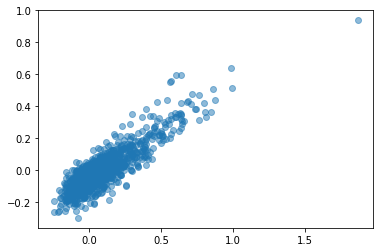

In [20]:
L_list = []
for exon in tqdm(chen_psix.index):
    L = px.calculate_exon_L(chen_PSI, W_chen, chen_reads_adj, exon, c = 0.1, 
                 randomize = False)
    L_list.append(L)

chen_psix['L_reads'] = L_list
plt.scatter(chen_psix.L_score, L_list, alpha=0.5)

In [ ]:
L_list = []
for exon in tqdm(song_psix.index):
    L = px.calculate_exon_L(song_PSI, W_song, song_reads_adj, exon, c = 0.1, 
                 randomize = False)
    L_list.append(L)

song_psix['L_reads'] = L_list
plt.scatter(song_psix.L_score, L_list, alpha=0.5)

In [5]:
tiklova_kw_scores_clusters = pd.read_csv('~/tiklova_kw_clusters.tab', sep='\t', index_col=0)
chen_kw_scores_clusters = pd.read_csv('~/chen_kw_clusters.tab', sep='\t', index_col=0)
song_kw_scores_clusters = pd.read_csv('~/song_kw_clusters.tab', sep='\t', index_col=0)

100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


Text(0.5, 1.0, 'Method comparison')

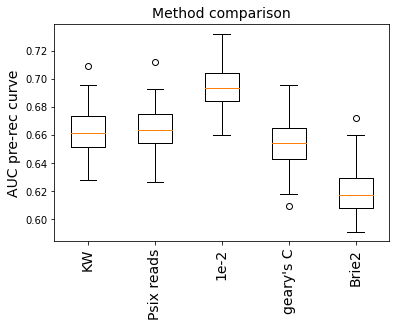

In [49]:
from sklearn.metrics import auc

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
L_e2_auc = []
L_reads_auc = []

c_auc = []
brie_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary.index)
    c_y = list(tiklova_geary.loc[pd.Index(pos_choice) & tiklova_geary.index].C_score) + list(tiklova_geary.loc[pd.Index(neg_choice) & tiklova_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    c_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    
    
    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(tiklova_psix.loc[pos_choice].L_reads) + list(tiklova_psix.loc[neg_choice].L_reads)
    pre, rec, thres = precision_recall_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_brie.index) + [0]*len(pd.Index(neg_choice) & tiklova_brie.index)
    brie_y = list(tiklova_brie.loc[pd.Index(pos_choice) & tiklova_brie.index].neuro_ELBO_gain) + list(tiklova_brie.loc[pd.Index(neg_choice) & tiklova_brie.index].neuro_ELBO_gain)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    brie_auc.append(auc(rec, pre))
    
    
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_e2_auc, c_auc, brie_auc]
)


plt.xticks(np.arange(1, 6), 
           ['KW', 'Psix reads', '1e-2', "geary's C", 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


100%|██████████| 100/100 [00:02<00:00, 46.04it/s]


Text(0.5, 1.0, 'Method comparison')

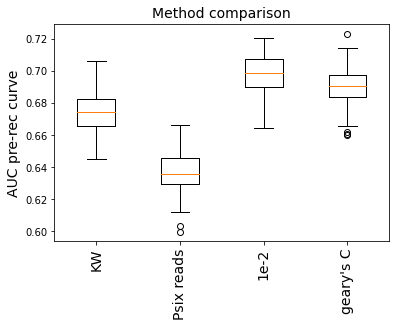

In [17]:
from sklearn.metrics import auc

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = chen_psix.index
exons_pos = hubbard_pos & exons
exons_neg = hubbard_neg & exons


kw_auc = []
L_e2_auc = []
L_reads_auc = []

c_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & chen_geary.index) + [0]*len(pd.Index(neg_choice) & chen_geary.index)
    c_y = list(chen_geary.loc[pd.Index(pos_choice) & chen_geary.index].C_score) + list(chen_geary.loc[pd.Index(neg_choice) & chen_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    c_auc.append(auc(rec, pre))
    

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(chen_psix.loc[pos_choice].L_score) + list(chen_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    
    kw_y = list(chen_kw.loc[pos_choice].KW_score) + list(chen_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(chen_psix.loc[pos_choice].L_reads) + list(chen_psix.loc[neg_choice].L_reads)
    pre, rec, thres = precision_recall_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))
    
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_e2_auc, c_auc]
)


plt.xticks(np.arange(1, 5), 
           ['KW', 'Psix reads', '1e-2', "geary's C"], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


100%|██████████| 100/100 [00:02<00:00, 45.33it/s]


Text(0.5, 1.0, 'Method comparison')

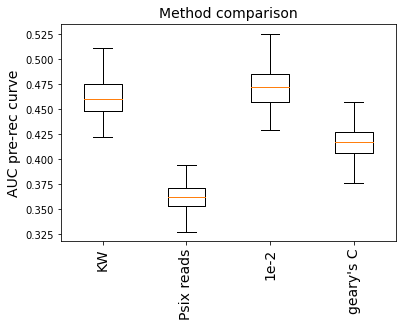

In [18]:
from sklearn.metrics import auc

song_bulk_pos = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) >= 0.2) & (song_bulk_fdr.min(axis=1) <= 0.05)]
song_bulk_neg = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) < 0.2) | (song_bulk_fdr.min(axis=1) > 0.05)]

exons = song_psix.index
exons_pos = song_bulk_pos & exons
exons_neg = song_bulk_neg & exons


kw_auc = []
L_e2_auc = []
L_reads_auc = []

c_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & song_geary.index) + [0]*len(pd.Index(neg_choice) & song_geary.index)
    c_y = list(song_geary.loc[pd.Index(pos_choice) & song_geary.index].C_score) + list(song_geary.loc[pd.Index(neg_choice) & song_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    c_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(song_psix.loc[pos_choice].L_score) + list(song_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    
    
    kw_y = list(song_kw.loc[pos_choice].KW_score) + list(song_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(song_psix.loc[pos_choice].L_reads) + list(song_psix.loc[neg_choice].L_reads)
    pre, rec, thres = precision_recall_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))
    
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_e2_auc, c_auc]
)


plt.xticks(np.arange(1, 5), 
           ['KW', 'Psix reads', '1e-2', "geary's C"], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


In [16]:
tiklova_rd.index

Index(['SRR7408400', 'SRR7408401', 'SRR7408404', 'SRR7408413', 'SRR7408414',
       'SRR7408418', 'SRR7408422', 'SRR7408424', 'SRR7408426', 'SRR7408427',
       ...
       'SRR7410086', 'SRR7410088', 'SRR7410089', 'SRR7410090', 'SRR7410091',
       'SRR7410092', 'SRR7410093', 'SRR7410094', 'SRR7410096', 'SRR7410097'],
      dtype='object', length=1197)

In [17]:
chen_kw_scores_clusters

,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
Aasdh_3,5.077451,5.077451,14.775475,14.775475,15.024270,15.449438,15.449438,15.449438,17.411836
Acadvl_1,0.661427,0.686903,0.703834,0.808916,0.906143,1.189424,1.632373,1.712662,2.786848
Actr3b_4,0.002622,0.407935,0.560645,4.916571,4.920745,4.997152,8.551775,12.237558,12.491957
Add1_7,0.111408,0.195250,2.063353,2.065354,2.066250,5.002097,7.090044,9.339802,11.458179
Add3_1,13.043792,57.174497,57.285195,114.264596,116.504871,116.882690,118.377948,126.706172,129.468968
...,...,...,...,...,...,...,...,...,...
Hnrnpa2b1_3,4.959284,5.619199,7.186211,10.116477,10.117927,10.344937,10.495916,10.552986,10.890511
Ndufa7_2,5.553817,16.389583,32.898703,61.693734,65.586765,65.619953,65.631353,65.881492,67.774941
Rps27l_2,28.598002,33.092956,33.096979,47.010571,59.481776,59.847422,60.249824,60.937344,61.643938
Srsf7_3,3.258289,8.400392,8.529937,9.134748,9.802634,12.193551,12.193636,21.350463,22.560926


100%|██████████| 100/100 [00:00<00:00, 311.67it/s]


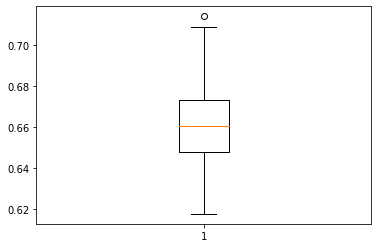

In [22]:
tiklova_kw_auc_list = []

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


for clu in tiklova_kw_scores_clusters.columns:
    kw_auc = []
    
    for sample in tqdm(range(100)):
        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        kw_y = list(tiklova_kw_scores_clusters.loc[pos_choice][clu]) + list(tiklova_kw_scores_clusters.loc[neg_choice][clu])
        pre, rec, thres = precision_recall_curve(y, kw_y)
        kw_auc.append(auc(rec, pre))
        
    tiklova_kw_auc_list.append(kw_auc)

    


In [27]:
chen_kw_auc_list = []

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = chen_psix.index
exons_pos = hubbard_pos & exons
exons_neg = hubbard_neg & exons


for clu in chen_kw_scores_clusters.columns:
    kw_auc = []
    
    for sample in tqdm(range(100)):
        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        kw_y = list(chen_kw_scores_clusters.loc[pos_choice][clu]) + list(chen_kw_scores_clusters.loc[neg_choice][clu])
        pre, rec, thres = precision_recall_curve(y, kw_y)
        kw_auc.append(auc(rec, pre))
        
    chen_kw_auc_list.append(kw_auc)

    


100%|██████████| 100/100 [00:00<00:00, 323.06it/s]


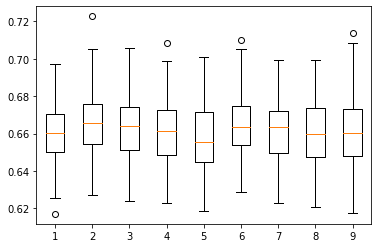

In [23]:
bp = plt.boxplot(
     tiklova_kw_auc_list
)

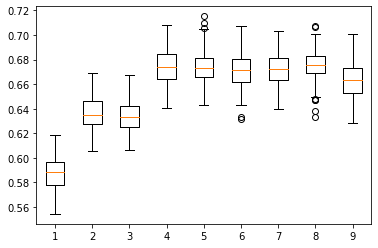

In [28]:
bp = plt.boxplot(
     chen_kw_auc_list
)

In [29]:
song_kw_auc_list = []

song_bulk_pos = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) >= 0.2) & (song_bulk_fdr.min(axis=1) <= 0.05)]
song_bulk_neg = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) < 0.2) | (song_bulk_fdr.min(axis=1) > 0.05)]

exons = song_psix.index
exons_pos = song_bulk_pos & exons
exons_neg = song_bulk_neg & exons


for clu in song_kw_scores_clusters.columns:
    kw_auc = []
    
    for sample in tqdm(range(100)):
        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        kw_y = list(song_kw_scores_clusters.loc[pos_choice][clu]) + list(song_kw_scores_clusters.loc[neg_choice][clu])
        pre, rec, thres = precision_recall_curve(y, kw_y)
        kw_auc.append(auc(rec, pre))
        
    song_kw_auc_list.append(kw_auc)

    


100%|██████████| 100/100 [00:00<00:00, 320.49it/s]


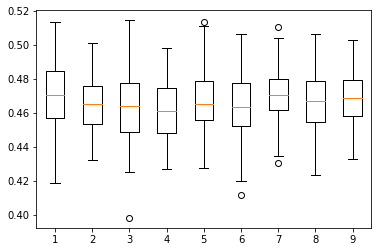

In [30]:
bp = plt.boxplot(
     song_kw_auc_list
)

In [20]:
# tiklova_kw_scores_clusters.to_csv('~/tiklova_kw_clusters.tab', sep='\t', index=True, header=True)
# chen_kw_scores_clusters.to_csv('~/chen_kw_clusters.tab', sep='\t', index=True, header=True)
# song_kw_scores_clusters.to_csv('~/song_kw_clusters.tab', sep='\t', index=True, header=True)

100%|██████████| 100/100 [00:01<00:00, 78.88it/s]


Text(0.5, 1.0, 'Method comparison')

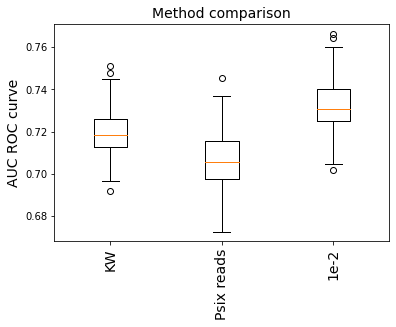

In [31]:
from sklearn.metrics import auc

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
L_e2_auc = []
L_reads_auc = []

L_sum_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
    rec, pre, thres = roc_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    rec, pre, thres = roc_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(tiklova_psix.loc[pos_choice].L_reads) + list(tiklova_psix.loc[neg_choice].L_reads)
    rec, pre, thres = roc_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))
    
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_e2_auc]
)


plt.xticks(np.arange(1, 4), 
           ['KW', 'Psix reads', '1e-2'], fontsize=14, rotation=90)

plt.ylabel('AUC ROC curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


In [9]:
psix_k_pd = pd.DataFrame()
for k in [30, 35, 50, 150, 200, 300, 400]:

    print('K = ' + str(k))
    temp_W = W_tiklova = get_distance_matrix(tiklova_rd[['PC_1', 'PC_2']], k=k)
    L_list = []
    for exon in tqdm(tiklova_psix.index):
        L = px.calculate_exon_L(tiklova_PSI, temp_W, tiklova_mrna_event, exon, c = 0.1, 
                     randomize = False)
        L_list.append(L)

    psix_k_pd['k_' + str(k)] = L_list


  1%|▏         | 17/1197 [00:00<00:07, 168.15it/s]

K = 30


  0%|          | 0/1988 [00:00<?, ?it/s]../utils/psix_functions.py:129: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))
 50%|████▉     | 993/1988 [01:57<03:00,  5.51it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:24<00:26,  3.19it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▋| 1915/1988 [04:27<00:18,  4.05it/s]../utils/psix_functions.py:46: RuntimeWarning: overflow encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
../utils/psix_functions.py:46: RuntimeWarning: invalid value encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
  1%|          | 12/1197 [00:00<00:10, 115.93it/s]

K = 35


  0%|          | 0/1988 [00:00<?, ?it/s]../utils/psix_functions.py:129: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))
 50%|████▉     | 993/1988 [01:56<02:55,  5.67it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:18<00:21,  3.99it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▋| 1915/1988 [04:20<00:17,  4.25it/s]../utils/psix_functions.py:46: RuntimeWarning: overflow encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
../utils/psix_functions.py:46: RuntimeWarning: invalid value encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
  1%|          | 9/1197 [00:00<00:14, 82.67it/s]

K = 50


  0%|          | 0/1988 [00:00<?, ?it/s]../utils/psix_functions.py:129: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))
 50%|████▉     | 993/1988 [01:56<03:27,  4.80it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:22<00:25,  3.28it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
  0%|          | 4/1197 [00:00<00:36, 32.66it/s]

K = 150


 50%|████▉     | 993/1988 [01:56<02:57,  5.59it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 51%|█████     | 1007/1988 [01:58<02:33,  6.39it/s]../utils/psix_functions.py:129: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))
 96%|█████████▌| 1904/1988 [04:19<00:20,  4.03it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
  0%|          | 3/1197 [00:00<00:47, 25.17it/s]

K = 200


 50%|████▉     | 993/1988 [01:56<03:35,  4.62it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:20<00:25,  3.27it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
  0%|          | 0/1197 [00:00<?, ?it/s]

K = 300


 50%|████▉     | 993/1988 [01:58<03:40,  4.52it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:24<00:26,  3.23it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
  0%|          | 0/1197 [00:00<?, ?it/s]

K = 400


 50%|████▉     | 993/1988 [01:57<03:37,  4.58it/s]../utils/psix_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [04:22<00:20,  4.16it/s]../utils/psix_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
100%|██████████| 1988/1988 [04:43<00:00,  7.00it/s]


In [11]:
psix_k_pd.index = tiklova_psix.index

In [12]:
psix_k_pd

,k_30,k_35,k_50,k_150,k_200,k_300,k_400
Adap1_1,-0.018839,-0.007000,-0.013969,-0.005849,-0.010418,-0.008637,-0.008091
Aftph_4,-0.013502,-0.013900,-0.021077,-0.001778,0.000632,0.007008,0.010702
Agrn_8,0.011892,0.016140,0.025100,0.032033,0.030829,0.031437,0.033319
Agtpbp1_11,-0.043750,-0.049925,-0.039423,-0.006188,-0.006329,-0.004963,-0.002821
Aldh3a2_2,-0.041900,-0.039269,-0.034095,-0.014119,-0.008027,-0.010872,-0.012336
...,...,...,...,...,...,...,...
Mapt_1,2.329202,2.331960,2.327656,2.242984,2.195647,2.023024,1.691611
Meg3_2,0.286960,0.290233,0.301074,0.308858,0.309505,0.310224,0.307320
Nnat_2,0.617655,0.621530,0.622496,0.633542,0.625848,0.614538,0.593762
Nnat_3,0.556461,0.557040,0.559833,0.570559,0.564546,0.556413,0.535860


100%|██████████| 200/200 [00:01<00:00, 123.01it/s]


Text(0.5, 1.0, 'Method comparison')

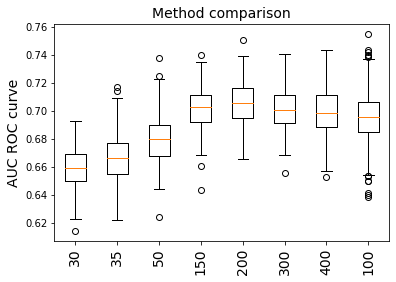

In [15]:
from sklearn.metrics import auc

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


psix_auc_list = []
L_e2_auc = []
for k in psix_k_pd.columns:
    
    psix_auc = []

    for sample in tqdm(range(200)):
    
        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

    
       

        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        psix_y = list(psix_k_pd.loc[pos_choice, k]) + list(psix_k_pd.loc[neg_choice, k])
        pre, rec, thres = precision_recall_curve(y, psix_y)
        psix_auc.append(auc(rec, pre))
        
        
        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
        pre, rec, thres = precision_recall_curve(y, psix_y)
        L_e2_auc.append(auc(rec, pre))
        
        
    psix_auc_list.append(psix_auc)
    
    
bp = plt.boxplot(
    psix_auc_list + [L_e2_auc]
)


plt.xticks(np.arange(1, 9), 
           ['30', '35', '50', '150', '200', '300', '400', '100'], fontsize=14, rotation=90)

plt.ylabel('AUC ROC curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


In [30]:
tiklova_PSI.loc[tiklova_psix.index].isna().mean(axis=1).median()

0.5772765246449457

In [32]:
35/.25

140.0

In [6]:
chen_brie = pd.read_csv('~/data_sc_regulation/chen_extended/brie2/brie_output_ordered/brie_quant_cell.brie_ident.tsv', 
                           sep='\t', index_col=0)
chen_brie_pseudo = pd.read_csv('~/data_sc_regulation/chen_extended/brie2/brie_output_pseudotime/brie_quant_cell.brie_ident.tsv', 
                                  sep='\t', index_col=0)

tiklova_brie = pd.read_csv('~/data_sc_regulation/tiklova_extended/brie2/brie_output_ordered/brie_quant_cell.brie_ident.tsv', 
                           sep='\t', index_col=0)
tiklova_brie_pseudo = pd.read_csv('~/data_sc_regulation/tiklova_extended/brie2/brie_output_pseudotime/brie_quant_cell.brie_ident.tsv', 
                                  sep='\t', index_col=0)

FileNotFoundError: [Errno 2] File /mnt/lareaulab/cfbuenabadn/data_sc_regulation/chen_extended/brie2/brie_output_ordered/brie_quant_cell.brie_ident.tsv does not exist: '/mnt/lareaulab/cfbuenabadn/data_sc_regulation/chen_extended/brie2/brie_output_ordered/brie_quant_cell.brie_ident.tsv'

In [6]:
one_v_one = '/mnt/lareaulab/cfbuenabadn/sc_splicing_modules/brain_development/brie2/label_v_label/'
tiklova_0v1 = pd.read_csv(one_v_one + 'brie_output_labels_1/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v2 = pd.read_csv(one_v_one + 'brie_output_labels_2/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v3 = pd.read_csv(one_v_one + 'brie_output_labels_3/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v4 = pd.read_csv(one_v_one + 'brie_output_labels_4/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v5 = pd.read_csv(one_v_one + 'brie_output_labels_5/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)


pt = '/mnt/lareaulab/cfbuenabadn/sc_splicing_modules/brain_development/brie2/pseudotime_runs/'

tiklova_brie_pseudo = pd.read_csv(pt + 'brie_output_pseudotime/brie_quant_cell.brie_ident.tsv', 
                                  sep='\t', index_col=0)

In [7]:
one_v_one = '/mnt/lareaulab/cfbuenabadn/sc_splicing_modules/mesc_neurogenesis/brie2/label_v_label/'
chen_0v1 = pd.read_csv(one_v_one + 'brie_output_labels_1/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
chen_0v2 = pd.read_csv(one_v_one + 'brie_output_labels_2/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
chen_0v3 = pd.read_csv(one_v_one + 'brie_output_labels_3/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)

pt = '~/sc_splicing_modules/mesc_neurogenesis/brie2/brie_output_pseudotime/brie_quant_cell.brie_ident.tsv'
chen_brie_pseudo = pd.read_csv(pt, sep='\t', index_col=0)

In [8]:
one_v_one = '/mnt/lareaulab/cfbuenabadn/sc_splicing_modules/ipsc_neurogenesis/brie2/label_v_label/'
song_0v1 = pd.read_csv(one_v_one + 'brie_output_labels_1/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
song_0v2 = pd.read_csv(one_v_one + 'brie_output_labels_2/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)

pt = '~/sc_splicing_modules/ipsc_neurogenesis/brie2/brie_output_pseudotime/brie_quant_cell.brie_ident.tsv'
song_brie_pseudo = pd.read_csv(pt, sep='\t', index_col=0)

In [56]:
tiklova_one_v_one = pd.DataFrame()
tiklova_one_v_one['0v1'] = tiklova_0v1.neuro_ELBO_gain
tiklova_one_v_one['0v2'] = tiklova_0v2.neuro_ELBO_gain
tiklova_one_v_one['0v3'] = tiklova_0v3.neuro_ELBO_gain
tiklova_one_v_one['0v4'] = tiklova_0v4.neuro_ELBO_gain
tiklova_one_v_one['0v5'] = tiklova_0v5.neuro_ELBO_gain
tiklova_ovo = tiklova_one_v_one.max(axis=1)

chen_one_v_one = pd.DataFrame()
chen_one_v_one['0v1'] = chen_0v1.neuro_ELBO_gain
chen_one_v_one['0v2'] = chen_0v2.neuro_ELBO_gain
chen_one_v_one['0v3'] = chen_0v3.neuro_ELBO_gain
chen_ovo = chen_one_v_one.max(axis=1)

song_one_v_one = pd.DataFrame()
song_one_v_one['0v1'] = song_0v1.neuro_ELBO_gain
song_one_v_one['0v2'] = song_0v2.neuro_ELBO_gain
song_ovo = song_one_v_one.max(axis=1)

In [49]:
tiklova_one_v_one = pd.DataFrame()
tiklova_one_v_one['0v1'] = tiklova_0v1.neuro_pval
tiklova_one_v_one['0v2'] = tiklova_0v2.neuro_pval
tiklova_one_v_one['0v3'] = tiklova_0v3.neuro_pval
tiklova_one_v_one['0v4'] = tiklova_0v4.neuro_pval
tiklova_one_v_one['0v5'] = tiklova_0v5.neuro_pval
tiklova_ovo = tiklova_one_v_one.min(axis=1)

chen_one_v_one = pd.DataFrame()
chen_one_v_one['0v1'] = chen_0v1.neuro_pval
chen_one_v_one['0v2'] = chen_0v2.neuro_pval
chen_one_v_one['0v3'] = chen_0v3.neuro_pval
chen_ovo = chen_one_v_one.min(axis=1)

song_one_v_one = pd.DataFrame()
song_one_v_one['0v1'] = song_0v1.neuro_pval
song_one_v_one['0v2'] = song_0v2.neuro_pval
song_ovo = song_one_v_one.min(axis=1)

In [48]:
song_brie_pseudo

,n_counts,n_counts_uniq,cdr,intercept,sigma,neuro_ceoff,neuro_ELBO_gain,neuro_pval,neuro_FDR
GeneID,,,,,,,,,
AAAS_3,25754,15548,0.4356,8.977,4.780,-0.030730,5.322000,0.001104,0.007468
AAMDC_3,39987,18150,0.5644,-6.105,5.105,0.005645,1.164000,0.127100,0.264100
AAMDC_6,25079,7434,0.4752,-2.751,6.978,-0.003264,0.669900,0.247100,0.407300
AAMDC_7,9340,3036,0.4505,-8.306,4.363,0.009257,0.028810,0.810300,1.000000
AARSD1_6,61673,24971,0.6287,7.450,4.613,-0.013050,1.297000,0.107300,0.235900
...,...,...,...,...,...,...,...,...,...
ZNHIT1_3,44418,13000,0.8069,-7.268,3.625,-0.002996,0.003906,0.929600,1.000000
ZNHIT3_1,48964,22033,0.7129,7.785,5.468,-0.036770,11.060000,0.000003,0.000058
ZRANB2_1,126615,18668,0.8465,2.187,5.535,-0.008335,-0.656200,1.000000,1.000000


In [24]:
song_geary

,C_score,pval,qvals
AAAS_2,0.054917,0.811519,0.916752
AAAS_3,0.597548,0.000500,0.003597
AAK1_1,0.721576,0.001200,0.007083
AAMDC_3,0.195934,0.114989,0.242660
AAMDC_5,0.256052,0.094591,0.209830
...,...,...,...
ZSWIM7_9,0.175688,0.090991,0.204166
ZSWIM7_nmdSE_3,0.093232,0.553145,0.723207
ZWILCH_1,0.372183,0.010399,0.039588
ZWILCH_7,0.648747,0.000100,0.001030


In [50]:
from sklearn.metrics import auc
from sklearn.metrics import f1_score

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
psix_auc = []
gearyc_auc = []
briep_auc = []
brie_l_auc = []

for sample in tqdm(range(500)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary.index)
#     c_y = list(tiklova_geary.loc[pd.Index(pos_choice) & tiklova_geary.index].C_score) + list(tiklova_geary.loc[pd.Index(neg_choice) & tiklova_geary.index].C_score)
#     pre, rec, thres = precision_recall_curve(y, c_y)
#     gearyc_auc.append(auc(rec, pre))
    c_y = list((tiklova_geary.loc[pd.Index(pos_choice) & tiklova_geary.index].pval <= 0.05).astype(int)) + list((tiklova_geary.loc[pd.Index(neg_choice) & tiklova_geary.index].pval <= 0.05).astype(int))
    f1 = f1_score(y, c_y)
    gearyc_auc.append(f1)

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
#     psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
#     pre, rec, thres = precision_recall_curve(y, psix_y)
#     psix_auc.append(auc(rec, pre))
    psix_y = list((tiklova_psix.loc[pos_choice].pvals <= 0.05).astype(int)) + list((tiklova_psix.loc[neg_choice].pvals <= 0.05).astype(int))
    psix_auc.append(f1_score(y, psix_y))
    
#     kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
#     pre, rec, thres = precision_recall_curve(y, kw_y)
#     kw_auc.append(auc(rec, pre))
    kw_y = list((tiklova_kw.loc[pos_choice].pvals <= 0.05).astype(int)) + list((tiklova_kw.loc[neg_choice].pvals <= 0.05).astype(int))
    kw_auc.append(f1_score(y, kw_y))
    
    #####r_y = list(tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]) + list(tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]])
    
#     r_y = list(tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]) + list(tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]])
#     pre, rec, thres = precision_recall_curve([1]*len([x for x in pos_choice if x in tiklova_ovo.index]) + [0]*len([x for x in neg_choice if x in tiklova_ovo.index]), r_y)
#     brie_l_auc.append(auc(rec, pre))
    r_y = list((tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]<=0.05).astype(int)) + list((tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]]<=0.05).astype(int))
    brie_l_auc.append(f1_score([1]*len([x for x in pos_choice if x in tiklova_ovo.index]) + [0]*len([x for x in neg_choice if x in tiklova_ovo.index]), r_y))
    #####
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_brie_pseudo.index) + [0]*len(pd.Index(neg_choice) & tiklova_brie_pseudo.index)
#     brie_y = list(tiklova_brie_pseudo.loc[pd.Index(pos_choice) & tiklova_brie_pseudo.index].neuro_ELBO_gain) + list(tiklova_brie_pseudo.loc[pd.Index(neg_choice) & tiklova_brie_pseudo.index].neuro_ELBO_gain)
#     pre, rec, thres = precision_recall_curve(y, brie_y)
#     briep_auc.append(auc(rec, pre))
    brie_y = list((tiklova_brie_pseudo.loc[pd.Index(pos_choice) & tiklova_brie_pseudo.index].neuro_pval<=0.05).astype(int)) + list((tiklova_brie_pseudo.loc[pd.Index(neg_choice) & tiklova_brie_pseudo.index].neuro_pval<=0.05).astype(int))
    briep_auc.append(f1_score(y, brie_y))
    



100%|██████████| 500/500 [00:17<00:00, 28.16it/s]


In [95]:
from sklearn.metrics import auc
from sklearn.metrics import f1_score

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
psix_auc = []
gearyc_auc = []
briep_auc = []
brie_l_auc = []

for sample in tqdm(range(500)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary.index)
    c_y = list(tiklova_geary.loc[pd.Index(pos_choice) & tiklova_geary.index].C_score) + list(tiklova_geary.loc[pd.Index(neg_choice) & tiklova_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    gearyc_auc.append(auc(rec, pre))
    

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    psix_auc.append(auc(rec, pre))

    
    kw_y = list(tiklova_kw_labels.loc[pos_choice].KW_score) + list(tiklova_kw_labels.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    
    #####r_y = list(tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]) + list(tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]])
    
    r_y = list(tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]) + list(tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]])
    pre, rec, thres = precision_recall_curve([1]*len([x for x in pos_choice if x in tiklova_ovo.index]) + [0]*len([x for x in neg_choice if x in tiklova_ovo.index]), r_y)
    brie_l_auc.append(auc(rec, pre))
    
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_brie_pseudo.index) + [0]*len(pd.Index(neg_choice) & tiklova_brie_pseudo.index)
    brie_y = list(tiklova_brie_pseudo.loc[pd.Index(pos_choice) & tiklova_brie_pseudo.index].neuro_ELBO_gain) + list(tiklova_brie_pseudo.loc[pd.Index(neg_choice) & tiklova_brie_pseudo.index].neuro_ELBO_gain)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    briep_auc.append(auc(rec, pre))
    


100%|██████████| 500/500 [00:14<00:00, 35.01it/s]


Text(0.5, 1.0, 'Method comparison, Tiklova dataset')

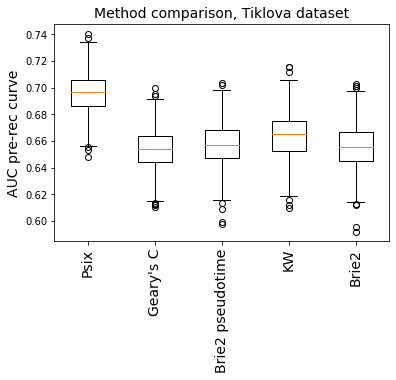

In [96]:
tiklova_boxplots = [ psix_auc, gearyc_auc, briep_auc, kw_auc, brie_l_auc]

# kw_auc = []
# psix_auc = []
# gearyc_auc = []
# briep_auc = []
# brie_l_auc = []

bp = plt.boxplot(tiklova_boxplots)


plt.xticks(np.arange(1, 6), 
           ['Psix', "Geary's C", 'Brie2 pseudotime', 'KW', 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Tiklova dataset', fontsize=14)

In [32]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [52]:
y_psix = list((tiklova_psix.loc[exons_pos].pvals <= 0.05).astype(int))
y_psix += list((tiklova_psix.loc[exons_neg].pvals <= 0.05).astype(int))
y = [1]*len(exons_pos) + [0]*len(exons_neg)
f1_score(y, y_psix)

0.6193548387096773

In [53]:
accuracy_score(y, y_psix)

0.6727676095396561

In [43]:
y_kw = list((tiklova_kw.loc[exons_pos].pvals <= 0.05).astype(int))
y_kw += list((tiklova_kw.loc[exons_neg].pvals <= 0.05).astype(int))
y = [1]*len(exons_pos) + [0]*len(exons_neg)
f1_score(y, y_kw)

0.5953286257468767

In [44]:
tiklova_kw

,KW_score,pvals,qvals
Adap1_1,4.079441,3.953615e-01,4.569643e-01
Aftph_4,19.178571,7.249247e-04,1.911340e-03
Agrn_8,63.632711,4.993702e-13,3.847860e-12
Agtpbp1_11,2.942466,5.674993e-01,6.209073e-01
Aldh3a2_2,1.699956,7.907257e-01,8.200118e-01
...,...,...,...
Mapt_1,686.520986,2.889012e-147,1.914452e-144
Meg3_2,309.947229,7.742218e-66,5.130510e-64
Nnat_2,569.782587,5.363944e-122,1.184836e-119
Nnat_3,546.347529,6.312005e-117,1.045689e-114


In [37]:
y_kw = list((tiklova_pval_all.loc[exons_pos & tiklova_pval_all.index] <= 0.05).astype(int))
y_kw += list((tiklova_pval_all.loc[exons_neg & tiklova_pval_all.index] <= 0.05).astype(int))
y = [1]*len(exons_pos & tiklova_pval_all.index) + [0]*len(exons_neg & tiklova_pval_all.index)
f1_score(y, y_kw)

NameError: name 'tiklova_pval_all' is not defined

In [56]:
accuracy_score(y, y_kw)

0.4910414333706607

In [57]:
tiklova_pval = pd.DataFrame()
tiklova_pval['0v1'] = tiklova_0v1.neuro_pval
tiklova_pval['0v2'] = tiklova_0v2.neuro_pval
tiklova_pval['0v3'] = tiklova_0v3.neuro_pval
tiklova_pval['0v4'] = tiklova_0v4.neuro_pval
tiklova_pval['0v5'] = tiklova_0v5.neuro_pval
tiklova_pval_all = tiklova_pval.min(axis=1)


chen_pval = pd.DataFrame()
chen_pval['0v1'] = chen_0v1.neuro_pval
chen_pval['0v2'] = chen_0v2.neuro_pval
chen_pval['0v3'] = chen_0v3.neuro_pval
chen_pval_all = chen_pval.max(axis=1)

song_pval = pd.DataFrame()
song_pval['0v1'] = song_0v1.neuro_pval
song_pval['0v2'] = song_0v2.neuro_pval
song_pval_all = song_pval.max(axis=1)

In [40]:
tiklova_fdr_all

GeneID
AW554918_2    2.572000e-01
Aak1_2        2.093000e-07
Aak1_5        9.620000e-05
Aamdc_9       2.312000e-01
Aamdc_10      3.791000e-01
                  ...     
Zyx_2         6.877000e-02
Zzz3_4        3.441000e-02
Zzz3_10       2.825000e-01
Zzz3_11       4.436000e-02
Zzz3_12       2.247000e-01
Length: 4430, dtype: float64

In [46]:
tiklova_0v1

,n_counts,n_counts_uniq,cdr,intercept,sigma,neuro_ceoff,neuro_ELBO_gain,neuro_pval,neuro_FDR
GeneID,,,,,,,,,
AW554918_2,4045,410,0.1421,0.6975,5.914,0.45120,-0.01843,1.00000,1.0000
Aak1_2,1097,383,0.1903,0.6049,6.375,2.11600,0.26830,0.46380,0.7431
Aak1_5,3966,1228,0.2627,5.0140,4.407,-3.34400,1.37800,0.09690,0.4055
Aamdc_9,4514,1751,0.2601,5.3790,5.425,0.54080,0.20750,0.51940,0.7888
Aamdc_10,9231,2124,0.2547,6.5350,4.815,0.30160,-0.20210,1.00000,1.0000
...,...,...,...,...,...,...,...,...,...
Zyx_2,3354,942,0.5603,1.1790,2.364,0.58650,0.92990,0.17260,0.4311
Zzz3_4,11877,10256,0.3137,4.4210,6.017,0.29560,1.65500,0.06888,0.2886
Zzz3_10,2431,589,0.2574,0.2980,4.113,-1.33400,0.20430,0.52260,0.7260


In [97]:
from sklearn.metrics import auc

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = chen_psix.index
exons_pos = hubbard_pos & exons
exons_neg = hubbard_neg & exons


kw_auc = []
psix_auc = []
gearyc_auc = []
briep_auc = []
brie_l_auc = []

for sample in tqdm(range(500)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & chen_geary.index) + [0]*len(pd.Index(neg_choice) & chen_geary.index)
    c_y = list(chen_geary.loc[pd.Index(pos_choice) & chen_geary.index].C_score) + list(chen_geary.loc[pd.Index(neg_choice) & chen_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    gearyc_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(chen_psix.loc[pos_choice].L_score) + list(chen_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    psix_auc.append(auc(rec, pre))
    
    kw_y = list(chen_kw_labels.loc[pos_choice].KW_score) + list(chen_kw_labels.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    #####
    
    r_y = list(chen_ovo.loc[[x for x in pos_choice if x in chen_ovo.index]]) + list(chen_ovo.loc[[x for x in neg_choice if x in chen_ovo.index]])
    pre, rec, thres = precision_recall_curve([1]*len([x for x in pos_choice if x in chen_ovo.index]) + [0]*len([x for x in neg_choice if x in chen_ovo.index]), r_y)
    brie_l_auc.append(auc(rec, pre))
    
    #####
    
    y = [1]*len(pd.Index(pos_choice) & chen_brie_pseudo.index) + [0]*len(pd.Index(neg_choice) & chen_brie_pseudo.index)
    brie_y = list(chen_brie_pseudo.loc[pd.Index(pos_choice) & chen_brie_pseudo.index].neuro_ELBO_gain) + list(chen_brie_pseudo.loc[pd.Index(neg_choice) & chen_brie_pseudo.index].neuro_ELBO_gain)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    briep_auc.append(auc(rec, pre))
    
    



100%|██████████| 500/500 [00:12<00:00, 39.74it/s]


Text(0.5, 1.0, 'Method comparison, Chen dataset')

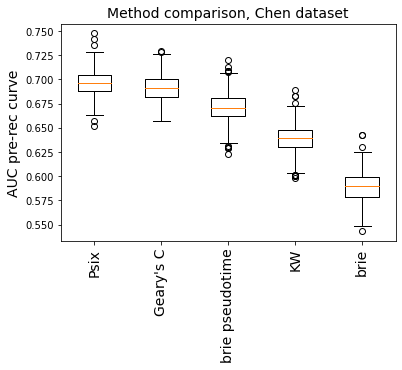

In [98]:
chen_boxplots = [psix_auc, gearyc_auc, briep_auc, kw_auc, brie_l_auc]


bp = plt.boxplot(chen_boxplots)


plt.xticks(np.arange(1, 6), 
           ['Psix', "Geary's C", 'brie pseudotime', 'KW', 'brie'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Chen dataset', fontsize=14)

In [99]:
from sklearn.metrics import auc

song_bulk_pos = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) >= 0.2) & (song_bulk_fdr.min(axis=1) <= 0.05)]
song_bulk_neg = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) < 0.2) | (song_bulk_fdr.min(axis=1) > 0.05)]

exons = song_psix.index
exons_pos = song_bulk_pos & exons
exons_neg = song_bulk_neg & exons


kw_auc = []
psix_auc = []
gearyc_auc = []
briep_auc = []
brie_l_auc = []

for sample in tqdm(range(500)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & song_geary.index) + [0]*len(pd.Index(neg_choice) & song_geary.index)
    c_y = list(song_geary.loc[pd.Index(pos_choice) & song_geary.index].C_score) + list(song_geary.loc[pd.Index(neg_choice) & song_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    gearyc_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(song_psix.loc[pos_choice].L_score) + list(song_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    psix_auc.append(auc(rec, pre))
    
    kw_y = list(song_kw_labels.loc[pos_choice].KW_score) + list(song_kw_labels.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    #####
    
    r_y = list(song_ovo.loc[[x for x in pos_choice if x in song_ovo.index]]) + list(song_ovo.loc[[x for x in neg_choice if x in song_ovo.index]])
    pre, rec, thres = precision_recall_curve([1]*len([x for x in pos_choice if x in song_ovo.index]) + [0]*len([x for x in neg_choice if x in song_ovo.index]), r_y)
    brie_l_auc.append(auc(rec, pre))
    
    #####
    
    y = [1]*len(pd.Index(pos_choice) & song_brie_pseudo.index) + [0]*len(pd.Index(neg_choice) & song_brie_pseudo.index)
    brie_y = list(song_brie_pseudo.loc[pd.Index(pos_choice) & song_brie_pseudo.index].neuro_ELBO_gain) + list(song_brie_pseudo.loc[pd.Index(neg_choice) & song_brie_pseudo.index].neuro_ELBO_gain)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    briep_auc.append(auc(rec, pre))
    
    



100%|██████████| 500/500 [00:12<00:00, 41.52it/s]


Text(0.5, 1.0, 'Method comparison, Song dataset')

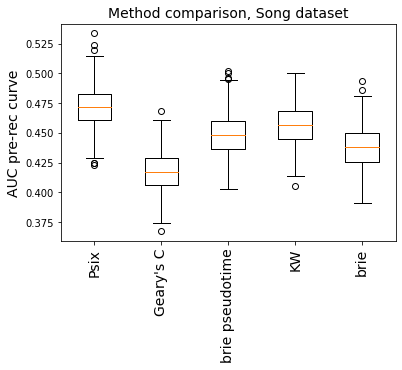

In [100]:
song_boxplots = [psix_auc, gearyc_auc, briep_auc, kw_auc, brie_l_auc]


bp = plt.boxplot(song_boxplots)


plt.xticks(np.arange(1, 6), 
           ['Psix', "Geary's C", 'brie pseudotime', 'KW', 'brie'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Song dataset', fontsize=14)

([<matplotlib.axis.XTick at 0x7f7dfb1f9b90>,
 [Text(0, 0, 'Tiklova'), Text(7, 0, 'Chen'), Text(14, 0, 'Song')])

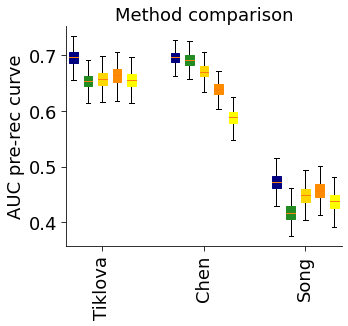

In [101]:
fig = plt.figure(figsize=(5,4))
ax  = plt.subplot(1,1,1)


bp_tiklova = ax.boxplot([tiklova_boxplots[0], chen_boxplots[0], song_boxplots[0]], positions = (0, 7, 14), 
                        sym='', widths=0.6, patch_artist=True,
                boxprops=dict(facecolor='navy', color='navy'))
bp_kw = ax.boxplot([tiklova_boxplots[1], chen_boxplots[1], song_boxplots[1]], positions = (1, 8, 15), 
                   sym='', widths=0.6, patch_artist=True,
                boxprops=dict(facecolor='forestgreen', color='forestgreen'))
bp_psix = ax.boxplot([tiklova_boxplots[2], chen_boxplots[2], song_boxplots[2]], positions = (2, 9, 16), 
                     sym='', widths=0.6, patch_artist=True,
                boxprops=dict(facecolor='gold', color='gold'))
bp_psix_r = ax.boxplot([tiklova_boxplots[3], chen_boxplots[3], song_boxplots[3]], positions = (3, 10, 17), 
                       sym='', widths=0.6, patch_artist=True,
                boxprops=dict(facecolor='darkorange', color='darkorange'))
bp_geary = ax.boxplot([tiklova_boxplots[4], chen_boxplots[4], song_boxplots[4]], positions = (4, 11, 18), 
                      sym='', widths=0.6, patch_artist=True,
                boxprops=dict(facecolor='yellow', color='yellow'))


ax.tick_params(labelsize=18, length=5)###
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# plt.xlabel('Bimodality limit', fontsize=28)
plt.ylabel('AUC pre-rec curve', fontsize=18)
plt.title('Method comparison', fontsize=18)

# plt.xticks(np.array(range(len(data_b)))*5.0, subpop_names)
#     plt.xticks(range(0, len(curves_all.columns[:-1]) * 7, 14), curves_all.columns[:-1][::2])
# plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
#     plt.xlim(-3, len(data_b)*7.0)
# plt.ylim(-0.05, 1.05)

plt.xticks([2, 9, 16], ['Tiklova', 'Chen', 'Song'], rotation=90)


###
#     plt.tick_params(labelsize=34, length=5)
###

    

(-2.05, -1.05)

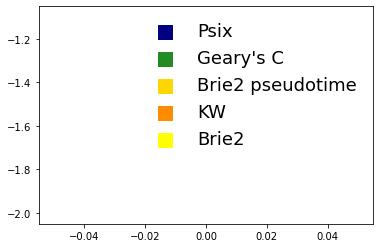

In [109]:
plt.scatter([0], [0], marker="s", c='navy', label='Psix', s=200)
plt.scatter([0], [0], marker="s", c='forestgreen', label="Geary's C", s=200)
plt.scatter([0], [0], marker="s", c='gold', label='Brie2 pseudotime', s=200)
plt.scatter([0], [0], marker="s", c='darkorange', label="KW", s=200)
plt.scatter([0], [0], marker="s", c='yellow', label='Brie2', s=200)
plt.legend(frameon=False, fontsize=18)
plt.ylim(-2.05, -1.05)


100%|██████████| 100/100 [00:02<00:00, 35.59it/s]


Text(0.5, 1.0, 'Method comparison, Tiklova dataset')

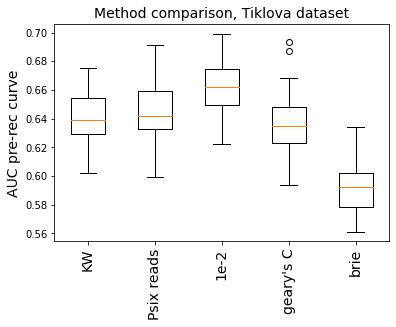

In [46]:
from sklearn.metrics import auc

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = hubbard_pos & exons
exons_neg = hubbard_neg & exons


kw_auc = []
L_e2_auc = []
L_reads_auc = []

c_auc = []

brie_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary.index)
    c_y = list(tiklova_geary.loc[pd.Index(pos_choice) & tiklova_geary.index].C_score) + list(tiklova_geary.loc[pd.Index(neg_choice) & tiklova_geary.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    c_auc.append(auc(rec, pre))
    

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    
    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(tiklova_psix.loc[pos_choice].L_reads) + list(tiklova_psix.loc[neg_choice].L_reads)
    pre, rec, thres = precision_recall_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))
    
    brie_y = list(-tiklova_brie.loc[pos_choice].neuro_pval) + list(-tiklova_brie.loc[neg_choice].neuro_pval)
    pre, rec, thres = precision_recall_curve(y, brie_y)
    brie_auc.append(auc(rec, pre))
    
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_e2_auc, c_auc, brie_auc]
)


plt.xticks(np.arange(1, 6), 
           ['KW', 'Psix reads', '1e-2', "geary's C", 'brie'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Tiklova dataset', fontsize=14)


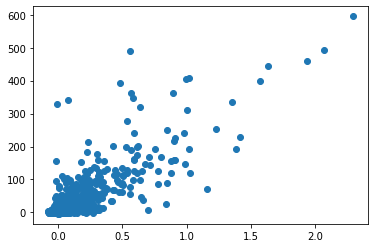

In [79]:
plt.scatter(
tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score, 
    tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain)

In [80]:
psix_max = tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score.max()
psix_min = tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score.min()
psix_adj = tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score/(psix_max-psix_min)


brie_max = tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain.max()
brie_min = tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain.min()
brie_adj = tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain/(brie_max-brie_min)

In [81]:
(psix_adj-brie_adj).sort_values()

Klc1_2     -0.579757
Nnat_7     -0.550623
Nnat_4     -0.533076
Nnat_6     -0.450731
Nnat_3     -0.360588
              ...   
Mbnl2_1     0.235846
Dst_5       0.263886
Micu1_4     0.285060
Camk2g_2    0.311260
Cadm1_3     0.373810
Length: 1987, dtype: float64

In [110]:
psi_o_array = tiklova_PSI.loc['Clta_4'].dropna()
cell_list = psi_o_array.index
psi_a_array = np.array(
        np.array(pd.DataFrame(
            np.array(W_tiklova.loc[cell_list, cell_list])*psi_o_array).sum(axis=1)
        )/np.array(W_tiklova.loc[cell_list, cell_list].sum(axis=1)))

Exception: Data must be 1-dimensional

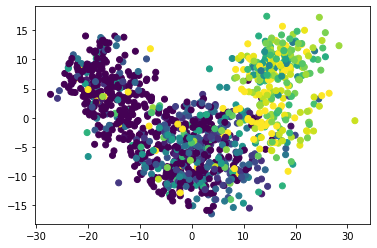

In [107]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Clta_4'])

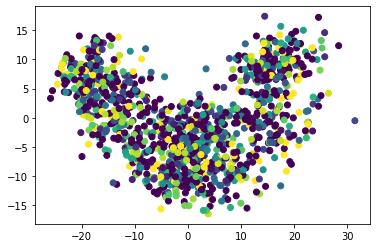

In [100]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, 
            c=np.random.choice(tiklova_PSI.loc['Clta_4'], len(tiklova_PSI.loc['Clta_4']), replace=False))

(array([508.,  57.,  92.,  66.,  53.,  59.,  55.,  67.,  70., 134.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

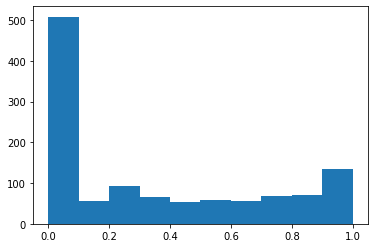

In [106]:
plt.hist(tiklova_PSI.loc['Clta_4'])

In [16]:
tiklova_brie

,n_counts,n_counts_uniq,cdr,intercept,sigma,neuro_ceoff,neuro_ELBO_gain,neuro_pval,neuro_FDR
GeneID,,,,,,,,,
AW554918_2,9543,1004,0.1763,0.2580,5.998,0.03228,0.2622,4.690000e-01,5.904000e-01
Aaed1_1,3599,1552,0.1921,4.2580,5.308,-0.40910,0.4321,3.525000e-01,4.708000e-01
Aak1_2,4150,1734,0.2732,1.5510,4.100,1.67800,15.3500,2.998000e-08,2.022000e-07
Aak1_5,9432,2659,0.3325,3.7150,4.563,-0.92940,7.6790,8.897000e-05,3.719000e-04
Aamdc_9,19247,7307,0.4645,5.9810,3.854,-0.42790,3.7200,6.381000e-03,1.646000e-02
...,...,...,...,...,...,...,...,...,...
Zyx_2,8810,2527,0.5856,1.5350,2.114,-0.18780,1.1540,1.287000e-01,2.303000e-01
Zzz3_4,22669,19288,0.2999,5.0000,6.109,-1.08200,5.1460,1.337000e-03,6.287000e-03
Zzz3_10,4904,1193,0.2490,0.3201,3.675,-0.01705,-0.9502,1.000000e+00,1.000000e+00


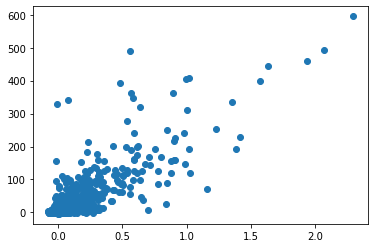

In [21]:
plt.scatter(tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score, 
            tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain)

In [24]:
min_L = tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score.min()
max_L = tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score.max()

psix_adj = (tiklova_psix.loc[tiklova_psix.index & tiklova_brie.index].L_score - min_L)/(max_L-min_L)

In [25]:
min_b = tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain.min()
max_b = tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain.max()

brie_adj = (tiklova_brie.loc[tiklova_psix.index & tiklova_brie.index].neuro_ELBO_gain - min_b)/(max_b-min_b)

In [27]:
(psix_adj - brie_adj).sort_values()

Klc1_2     -0.555875
Nnat_7     -0.526740
Nnat_4     -0.509193
Nnat_6     -0.426849
Nnat_3     -0.336705
              ...   
Mbnl2_1     0.259728
Dst_5       0.287768
Micu1_4     0.308942
Camk2g_2    0.335142
Cadm1_3     0.397693
Length: 1987, dtype: float64

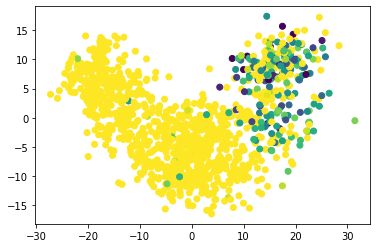

In [33]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Klc1_2'])

In [35]:
tiklova_psix.loc['Klc1_2']

bin           mean_3_var_1
L_score           0.558127
pvals          0.000999001
qvals           0.00376853
norm_pvals               0
norm_qvals               0
Name: Klc1_2, dtype: object

In [42]:
tiklova_brie.loc[tiklova_brie.neuro_ELBO_gain < 0].index & tiklova_psix.loc[tiklova_psix.L_score >0.1].index

Index(['Caly_1', 'Nrxn1_4', 'Ppip5k2_4', 'Snhg11_nmdSE_1'], dtype='object')

In [40]:
tiklova_psix.loc[tiklova_psix.L_score >0.1].index

Index(['Agrn_11', 'Clasp1_17', 'Eml1_3', 'Epb41_2', 'Map4_16', 'Abi2_2',
       'Alcam_1', 'Baz2b_4', 'C2cd5_2', 'Clstn1_2',
       ...
       'Tecr_6', 'Cadm1_10', 'Cadm1_4', 'Ncam1_6', 'Ndrg4_1', 'Mapt_1',
       'Meg3_2', 'Nnat_2', 'Nnat_3', 'Nnat_6'],
      dtype='object', length=278)

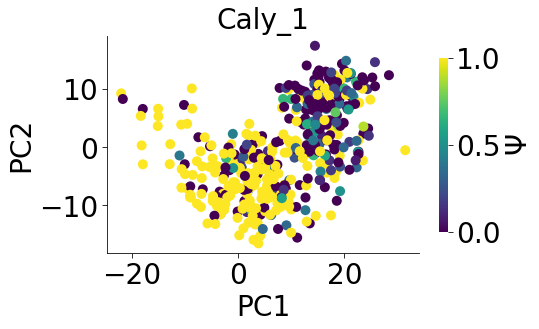

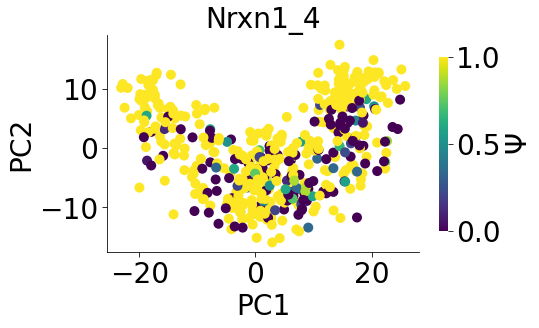

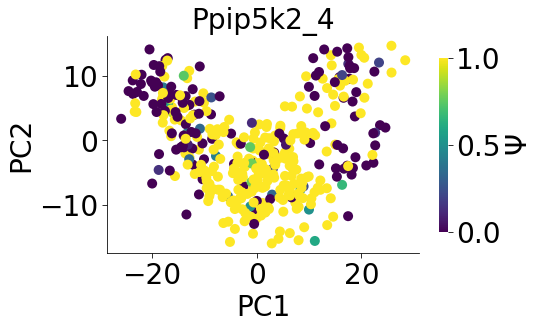

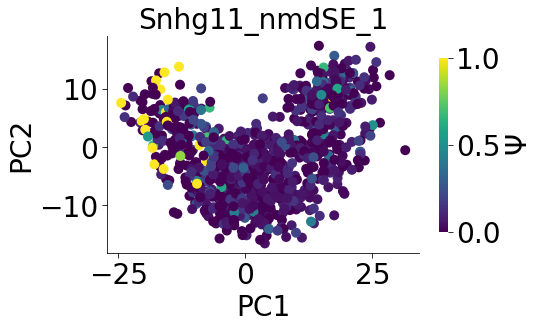

In [56]:
# figsize(width, 5)
for exon in (tiklova_brie.loc[tiklova_brie.neuro_ELBO_gain < 0].index & tiklova_psix.loc[tiklova_psix.L_score >0.1].index):
    fig = plt.figure(figsize=(7, 4))
    ax  = plt.subplot(1,1,1)
    sc = ax.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc[exon], s=100, edgecolors='none')

    ax.tick_params(labelsize=28, length=5)
    cb = plt.colorbar(sc, shrink = 0.8)
    cb.set_label(label='$\Psi$',size=28)
    cb.ax.tick_params(labelsize=28, length=5)
    cb.outline.set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(labelsize=28, length=5)

    plt.ylabel('PC2', fontsize=28)
    plt.xlabel('PC1', fontsize=28)
    plt.title(exon, fontsize=28)
    plt.show()

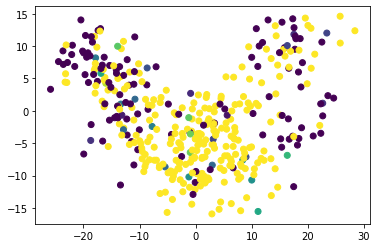

In [47]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Ppip5k2_4'])

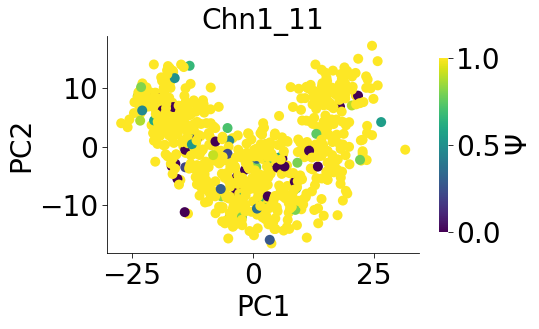

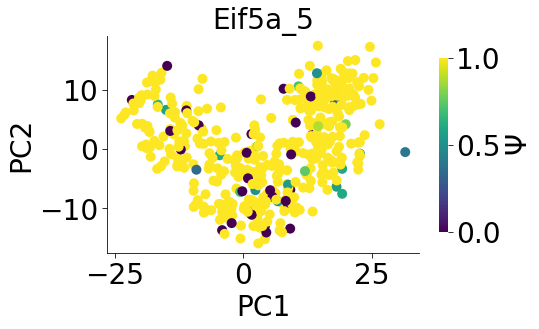

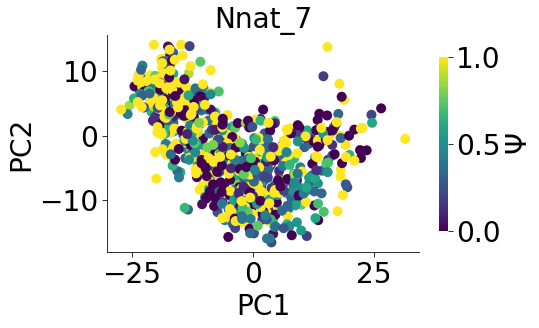

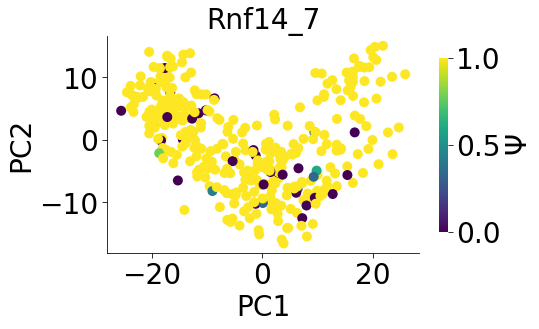

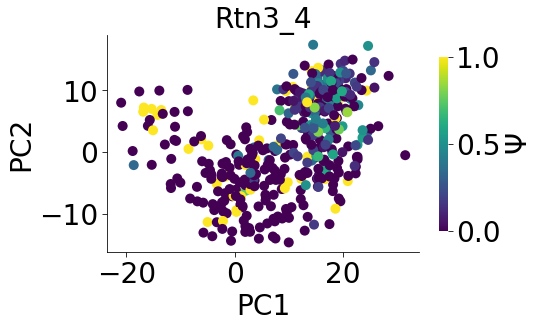

In [57]:
# figsize(width, 5)
for exon in (tiklova_brie.loc[tiklova_brie.neuro_ELBO_gain > 30].index & tiklova_psix.loc[tiklova_psix.L_score <0].index):
    fig = plt.figure(figsize=(7, 4))
    ax  = plt.subplot(1,1,1)
    sc = ax.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc[exon], s=100, edgecolors='none')

    ax.tick_params(labelsize=28, length=5)
    cb = plt.colorbar(sc, shrink = 0.8)
    cb.set_label(label='$\Psi$',size=28)
    cb.ax.tick_params(labelsize=28, length=5)
    cb.outline.set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(labelsize=28, length=5)

    plt.ylabel('PC2', fontsize=28)
    plt.xlabel('PC1', fontsize=28)
    plt.title(exon, fontsize=28)
    plt.show()

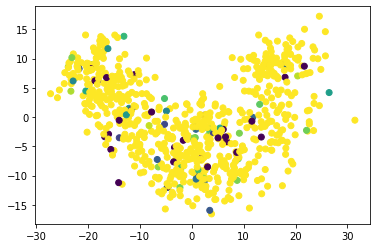

In [52]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Chn1_11'])

In [71]:
tiklova_W

NameError: name 'tiklova_W' is not defined